In [20]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

# Se transforman los datos, se crean variables exogenas y se coloca la columna datetime como indice

In [21]:
df = pd.read_csv("Final-db.csv")
# Eliminar los espacios adicionales en las fechas
df['date'] = df['date'].str.strip()

# Mapeo de los nombres de los meses en español a los nombres en inglés
meses = {
    'ene': 'Jan',
    'feb': 'Feb',
    'mar': 'Mar',
    'abr': 'Apr',
    'may': 'May',
    'jun': 'Jun',
    'jul': 'Jul',
    'ago': 'Aug',
    'sep': 'Sep',
    'oct': 'Oct',
    'nov': 'Nov',
    'dic': 'Dec'
}

# Función para convertir los nombres de los meses en español a inglés
def convertir_meses(fecha):
    for mes_es, mes_en in meses.items():
        fecha = fecha.replace(mes_es, mes_en)
    return fecha

# Aplicar la función a la columna de fecha
df['date'] = df['date'].apply(convertir_meses)

# Convertir la columna de fecha a datetime
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')

In [22]:

df = df.drop(columns=['Unnamed: 0',"index","Total libre de impuestos","Indefinido total $","Indefinido ctdad"])
df = df.rename(columns={"date":"Fecha","Encoded Products":"Producto"})
df['Fecha'] = pd.to_datetime(df['Fecha'], format="mixed")
df.columns = df.columns.str.replace("total $", "Precio por unidad")
df.columns = df.columns.str.replace("ctdad", "Cantidad")
def div(numerator, denominator):
  return lambda row: 0.0 if row[denominator] == 0 else float(row[numerator]/row[denominator])
for i in range(2, len(df.columns)-1,2):
    df[df.columns[i]] = df.apply(div(df.columns[i], df.columns[i+1]), axis=1)
df = df.set_index('Fecha')



# Se eliminan las columnas de más, de igual manera se eliminan los productos con menos de 50 ventas en 2023

In [23]:
data = pd.DataFrame()
for i in df["Producto"].unique():
        x =pd.DataFrame(df[df["Producto"]==i].loc[:].groupby("Fecha").sum()["Ctdad Ordenada"].asfreq("D", fill_value=0)).rename(columns={"Ctdad Ordenada":i})
        data = pd.concat([data,x], axis=1)
data.fillna(0, inplace=True)
exog = pd.DataFrame()
exog["Mes"] = data.index.month
data["Dia"] = data.index.day
exog["Dia de la semana"] = data.index.dayofweek
exog.index = data.index
exog = pd.get_dummies(exog, columns=["Mes","Dia de la semana"],dtype=int)
exog = pd.concat([exog, data["Dia"]], axis=1)
exog
exog["Dia"].replace(to_replace=[13,14,15,16,17,18,28,29,30,31,1,2], value=1, inplace=True)
exog["Dia"].replace(to_replace=[3,4,5,6,7,8,9,10,11,12,19,20,21,22,23,24,25,26,27,28], value=0, inplace=True)
for i in data.columns:
    if data.loc["2023-01-01":,i].sum() < 50:
        data = data.drop(columns=i,axis=1)
data.drop(columns="Dia", inplace=True)
data = data[data.sum().sort_values(ascending=False).index[0:20]]
data.head()

,Producto 273,Producto 0,Producto 1,Producto 5,Producto 8,Producto 21,Producto 12,Producto 22,Producto 186,Producto 20,Producto 33,Producto 245,Producto 16,Producto 17,Producto 38,Producto 134,Producto 37,Producto 59,Producto 248,Producto 122
Fecha,,,,,,,,,,,,,,,,,,,,
2022-01-02,0.0,10.5,35.0,14.0,21.0,7.0,7.0,0.0,0.0,3.5,0.0,0.0,3.5,0.0,0.0,0.0,7.0,0.0,0.0,0.0
2022-01-03,0.0,38.5,17.5,21.0,0.0,7.0,10.5,3.5,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,3.5,0.0,0.0
2022-01-04,0.0,56.0,3.5,21.0,10.5,3.5,3.5,7.0,0.0,3.5,7.0,0.0,3.5,0.0,0.0,0.0,3.5,0.0,0.0,0.0
2022-01-05,0.0,49.0,14.0,10.5,10.5,0.0,7.0,3.5,0.0,0.0,0.0,0.0,3.5,3.5,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-06,0.0,17.5,7.0,10.5,3.5,3.5,7.0,0.0,0.0,0.0,0.0,0.0,7.0,3.5,0.0,0.0,0.0,3.5,0.0,0.0


In [24]:
exog.head()

,Mes_1,Mes_2,Mes_3,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Mes_10,Mes_11,Mes_12,Dia de la semana_0,Dia de la semana_1,Dia de la semana_2,Dia de la semana_3,Dia de la semana_4,Dia de la semana_5,Dia de la semana_6,Dia
Fecha,,,,,,,,,,,,,,,,,,,,
2022-01-02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2022-01-03,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2022-01-04,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2022-01-05,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2022-01-06,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Se divide el test en validacion, test y entrenamiento

In [25]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2023-10-30'
end_val = '2023-11-30'

data_train = data.loc[:end_train, :].copy()
data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()
exog_train = exog.loc[:end_train, :].copy()
exog_val   = exog.loc[end_train:end_val, :].copy()
exog_test  = exog.loc[end_val:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2022-01-02 00:00:00 --- 2023-10-30 00:00:00  (n=667)
Validation dates : 2023-10-30 00:00:00 --- 2023-11-30 00:00:00  (n=32)
Test dates       : 2023-11-30 00:00:00 --- 2023-12-31 00:00:00  (n=32)


Algunas de los trends que hay

C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_5440\694730855.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


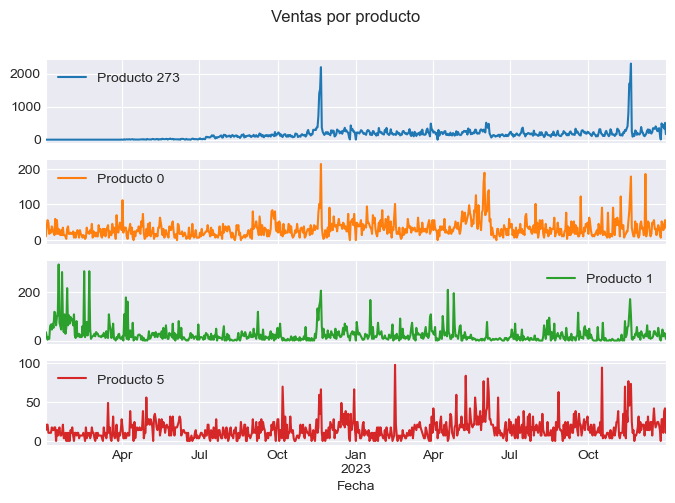

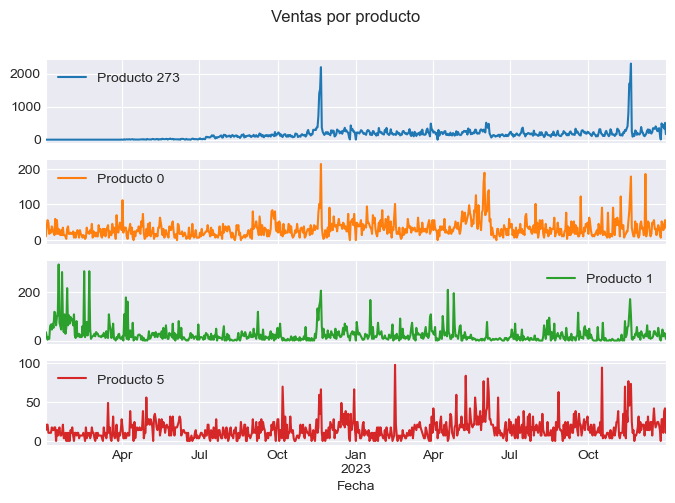

In [26]:
# Plot time series
# ======================================================================================
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend   = True,
    subplots = True, 
    sharex   = True,
    title    = 'Ventas por producto',
    ax       = ax, 
)
fig

In [27]:
from tqdm import tqdm
from functools import partialmethod

## Se buscan los mejores hiperparametros para el modelo por grid-search y se guardan en un dataframe

In [28]:
# Hyperparameter search and backtesting of each item's model
# ======================================================================================
items = []
mae_values  = []
dictes = {}

lags_grid = [7, 14, 21]
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

for i, item in enumerate(data.columns):

    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=123),
                     lags          = 14,
                     transformer_y = StandardScaler()
                 )

    results_grid = grid_search_forecaster(
                       forecaster         = forecaster,
                       y                  = data.loc[:end_val, item],
                       lags_grid          = lags_grid,
                       param_grid         = param_grid,
                       steps              = 7,
                       exog=exog.loc[:end_val, :],
                       metric             = "mean_absolute_error",
                       initial_train_size = len(data_train),
                       refit              = False,
                       fixed_train_size   = False,
                       return_best        = True,
                       verbose            = False,
                       show_progress      = False 
                  )

    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[item],
                        exog=exog,
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 7,
                        metric             = "mean_absolute_error",
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False,
                        show_progress      = False
                    )

    items.append(item)
    mae_values.append(metric)
    dictes[item] = results_grid
    

uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

Number of models compared: 36.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_iter': 100}
  Backtesting metric: 264.4963276077366

Number of models compared: 36.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100}
  Backtesting metric: 26.48353771142115

Number of models compared: 36.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_iter': 100}
  Backtesting metric: 28.431921601843328

Number of models compared: 36.
`Forecaster` refitted using the best-found lags a

# Se procede a hacer un modelo para cada uno de ellos.

Se puede guardar cada modelo en un csv, que puede ser releido para usarse en el futuro, pero es recomendable reentrenar cada semna

In [29]:
for i in dictes.keys():
    #dictes[i].to_csv(f"dictes_{i}.csv")
    dictes[i]["Producto"] = i

Se crea un dataframe con cada uno de los parametros necesarios

In [30]:
models = pd.DataFrame()
for i in dictes.keys():
    models = pd.concat([models, dictes[i][["lags","learning_rate","max_depth","max_iter","Producto","mean_absolute_error"]].head(1)], axis=0)
models.index = models["Producto"]
models["max_depth"] = models["max_depth"].astype(int)
models["max_iter"] = models["max_iter"].astype(int)
models.loc["Producto 273","max_iter"]= 500
#models.to_csv("modelsHGB.csv")

Se entrena cada modelo y se predice para una semana y para un mes, se guarda en un dataframe cada predicción

In [31]:
month_pred = pd.DataFrame()
week_pred = pd.DataFrame()

In [32]:
for i in models.index:
    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=123, max_depth=models.loc[i,"max_depth"], max_iter=models.loc[i,"max_iter"], learning_rate=models.loc[i,"learning_rate"]),
                     lags          = [models.loc[i,"lags"].max()],
                     transformer_y = StandardScaler()
                 )
    forecaster.fit(y=data.loc[:"2023-11-30",i], exog=exog.loc[:"2023-11-30", :])
    month_pred[i] = forecaster.predict(steps=31, exog=exog.loc["2023-12-01":])
    week_pred[i] = forecaster.predict(steps=8, exog=exog.loc["2023-12-01":])

Se ayuda un poco al modelo dado que los valores negativos no existen en los productos

In [33]:
# cambiar valores negativos a 0
month_pred[month_pred<0] = 0
week_pred[week_pred<0] = 0

In [34]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

Se consiguen las estadisticas que tiene el modelo para predecir durante un mes y durante una semana

In [35]:
stats_mes = pd.DataFrame()
for i in month_pred.columns:
    y_pred = month_pred[i]
    y_test = data.loc["2023-12-01":"2023-12-31",i]
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mape2 = abs((y_pred - y_test)/y_test).replace([np.inf, -np.inf], np.log(0.9999999999999999999999999)).dropna().sum()/30
    mape3 = (np.abs((y_test - y_pred)/np.where(y_test==0, 1, y_test))).mean()
    smape = 1/len(y_test) * np.sum(2*np.abs(y_pred - y_test)/(np.abs(y_pred) + np.abs(y_test))*100)
    valor_real = y_test.sum()
    valor_pred = y_pred.sum()
    error = (valor_real - valor_pred)/valor_real
    error_semanal = error/4 * 100
    stats_mes = pd.concat([stats_mes, pd.DataFrame({"Producto":i, "MAE":mae, "MSE":mse, "R2":r2, "SMAPE": smape,"MAPE lib":mape,"MAPE2":mape2,"MAPE3":mape3, "valor real": 
        valor_real, "valor predecido": valor_pred, "error":error*100, "error por semana": error_semanal}, index=[0])], axis=0)
stats_mes

C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_5440\1630151674.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  error = (valor_real - valor_pred)/valor_real


,Producto,MAE,MSE,R2,SMAPE,MAPE lib,MAPE2,MAPE3,valor real,valor predecido,error,error por semana
0,Producto 273,95.793754,15217.656038,-0.171916,38.714044,1.451618e+00,1.500005,1.451618,8452.5,6935.372539,17.948861,4.487215
0,Producto 0,18.286359,1003.474879,-0.075167,45.931559,8.522957e-01,0.880706,0.852296,1186.5,1316.897688,-10.990113,-2.747528
0,Producto 1,12.395970,220.389846,-0.029128,56.568876,3.898879e+15,0.894437,1.731309,731.5,810.692673,-10.826066,-2.706517
0,Producto 5,7.568829,101.837021,-0.120478,38.743569,3.745069e+15,0.473572,1.289868,651.0,697.175864,-7.093067,-1.773267
0,Producto 8,6.164464,59.024440,0.256040,57.239842,5.250339e+15,0.647157,1.792090,399.0,444.534648,-11.412192,-2.853048
0,Producto 21,3.218037,15.420351,-0.326437,115.200718,3.110624e+15,0.397368,1.075247,133.0,76.064086,42.808958,10.702239
0,Producto 12,2.020074,7.477569,0.053859,76.989850,4.449879e+15,0.148671,1.131946,108.5,107.332802,1.075758,0.268940
0,Producto 22,3.103092,13.229094,-0.333945,130.604673,1.018220e+16,0.115641,2.372813,70.0,118.648808,-69.498297,-17.374574
0,Producto 186,5.286273,38.350348,-0.320696,90.903108,9.108969e+15,0.439951,2.448357,203.0,233.814536,-15.179575,-3.794894
0,Producto 20,1.415677,2.990410,0.137520,145.006665,3.537359e+15,0.163922,0.944086,35.0,39.812001,-13.748574,-3.437143


In [36]:
stats_semana = pd.DataFrame()
for i in month_pred.columns:
    y_pred = week_pred[i]
    y_test = data.loc["2023-12-01":"2023-12-8",i]
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mape2 = abs((y_pred - y_test)/y_test).replace([np.inf, -np.inf], np.log(0.9999999999999999999999999)).dropna().sum()/30
    mape3 = (np.abs((y_test - y_pred)/np.where(y_test==0, 1, y_test))).mean()
    smape = 1/len(y_test) * np.sum(2*np.abs(y_pred - y_test)/(np.abs(y_pred) + np.abs(y_test))*100)
    valor_real = y_test.sum()
    valor_pred = y_pred.sum()
    error = (valor_real - valor_pred)/valor_real *100
    stats_semana = pd.concat([stats_semana, pd.DataFrame({"Producto":i, "MAE":mae, "MSE":mse, "R2":r2, "SMAPE": smape,"MAPE lib":mape,"MAPE2":mape2,"MAPE3":mape3, "valor real": 
        valor_real, "valor predecido": valor_pred, "error":error}, index=[0])], axis=0)
stats_semana

C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_5440\2497161326.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  error = (valor_real - valor_pred)/valor_real *100
C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_5440\2497161326.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  error = (valor_real - valor_pred)/valor_real *100


,Producto,MAE,MSE,R2,SMAPE,MAPE lib,MAPE2,MAPE3,valor real,valor predecido,error
0,Producto 273,52.346240,4202.757693,0.365819,26.245740,3.185085e-01,0.084936,0.318509,1585.5,1711.417806,-7.941836
0,Producto 0,31.196143,2991.057848,-0.046808,60.095193,9.134583e-01,0.243589,0.913458,392.0,333.567139,14.906342
0,Producto 1,10.685492,151.653224,-0.437950,52.958992,1.259597e+00,0.335893,1.259597,164.5,209.707703,-27.481886
0,Producto 5,4.024606,31.415018,-0.032248,24.541844,3.363593e-01,0.089696,0.336359,150.5,165.441314,-9.927783
0,Producto 8,6.666298,68.199411,-1.240925,91.036889,1.441358e+16,0.223963,4.040318,45.5,98.830380,-117.209627
0,Producto 21,2.754933,9.081938,-0.482765,111.583601,3.493695e+15,0.113508,1.201412,28.0,18.372639,34.383434
0,Producto 12,1.300566,4.308337,-0.500591,24.839629,1.902599e-01,0.050736,0.190260,38.5,28.106424,26.996300
0,Producto 22,3.524867,14.119302,-9.538021,176.440046,1.563373e+16,0.004075,3.486665,3.5,31.698934,-805.683841
0,Producto 186,7.046090,60.093318,-0.794040,136.798306,1.827215e+16,0.081019,4.361053,38.5,54.992778,-42.838384
0,Producto 20,0.804632,0.846046,0.368549,156.693373,2.791506e+15,0.014079,0.672637,3.5,6.980370,-99.439149


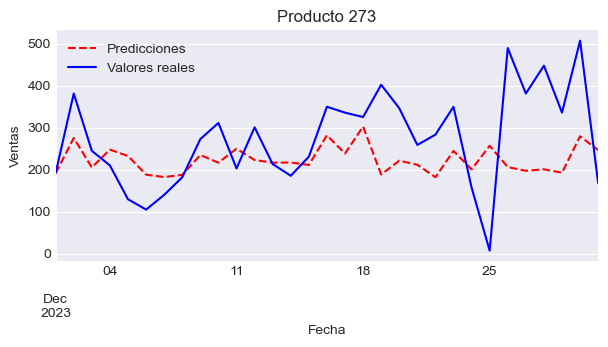

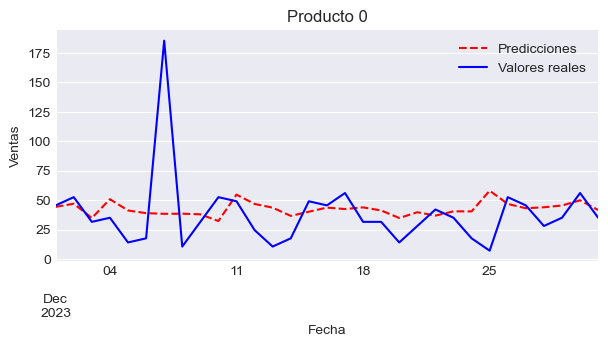

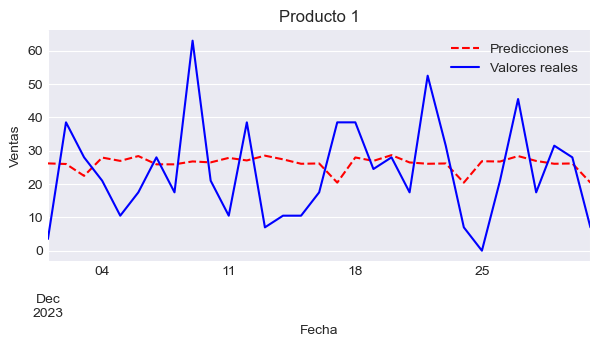

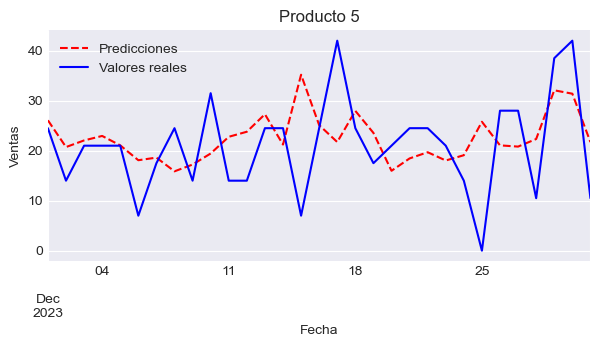

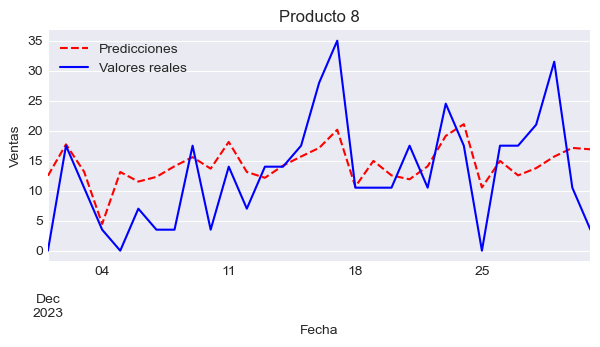

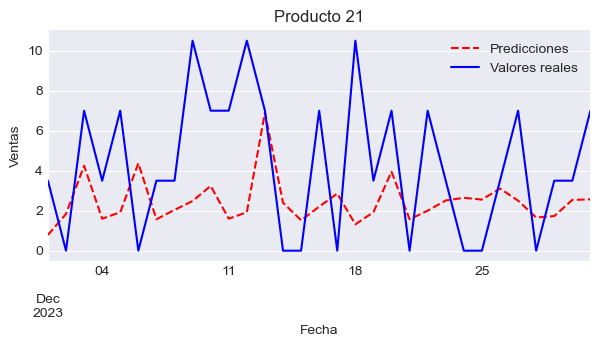

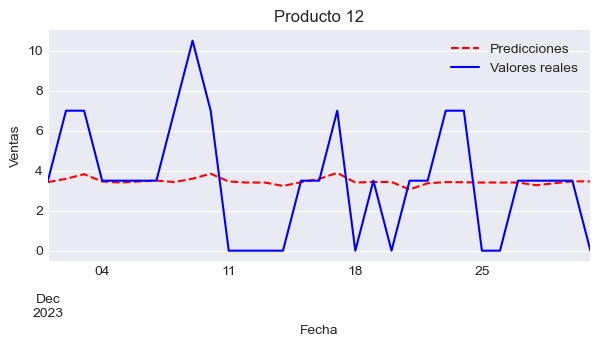

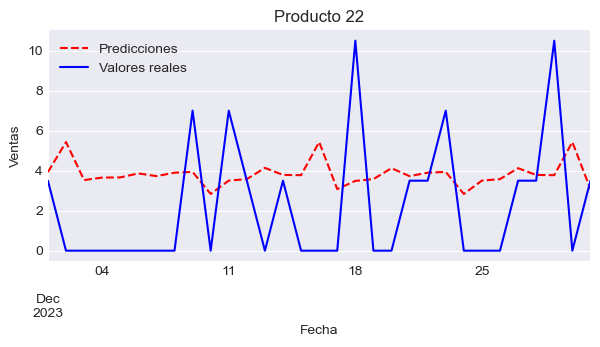

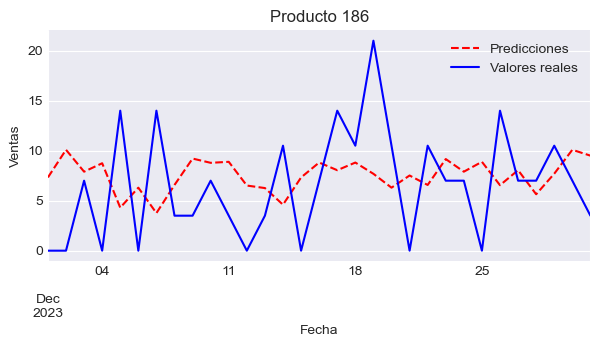

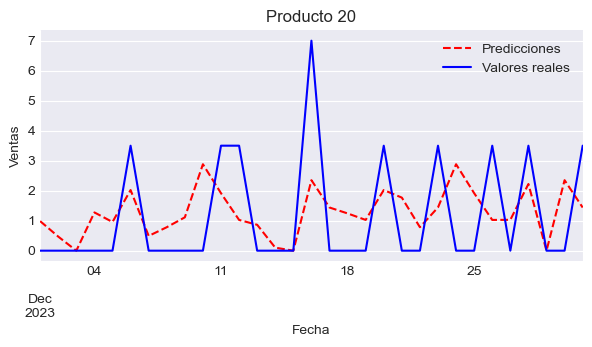

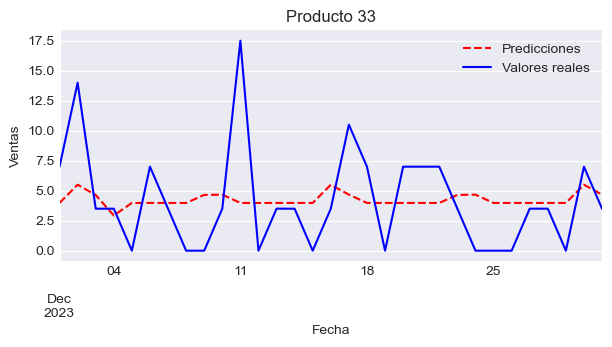

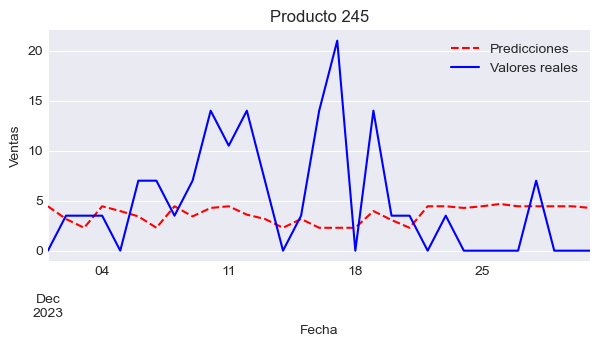

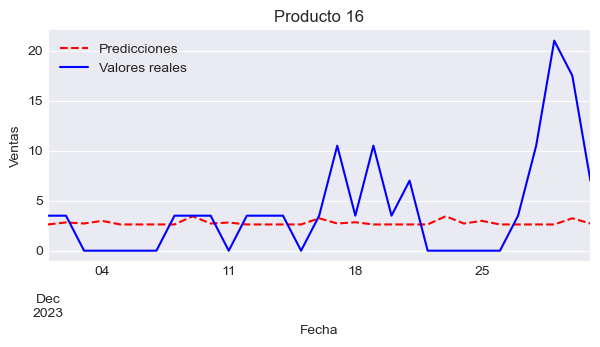

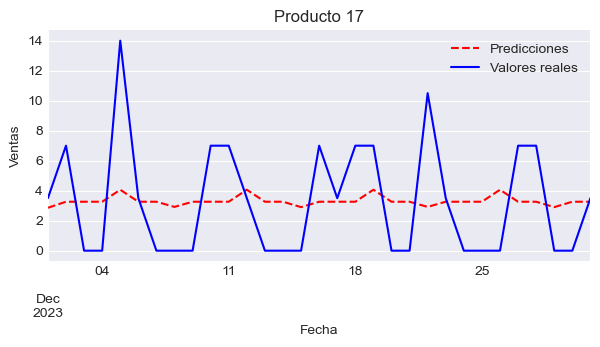

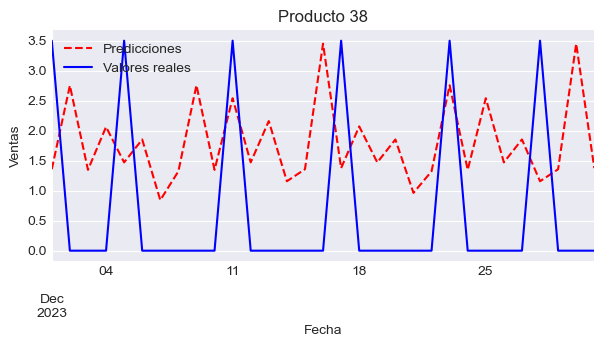

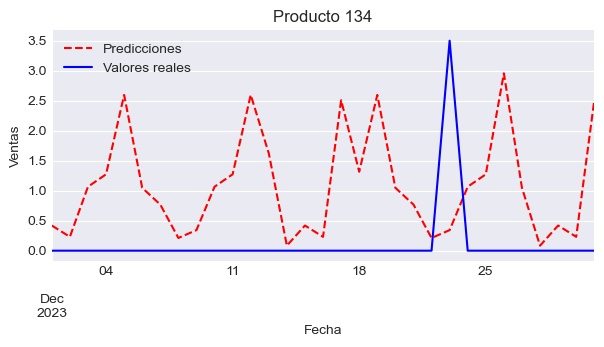

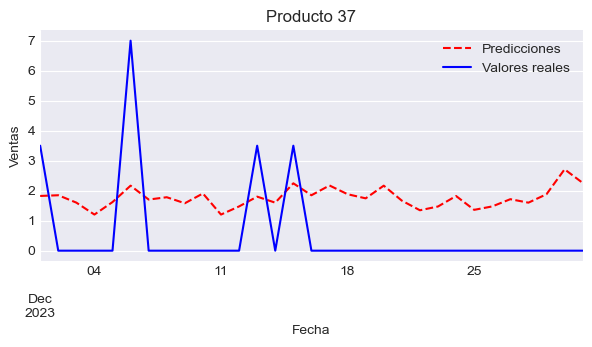

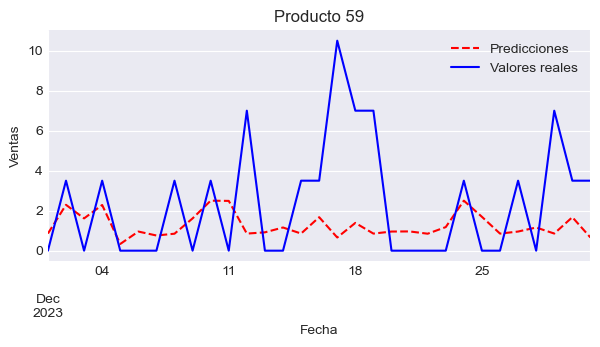

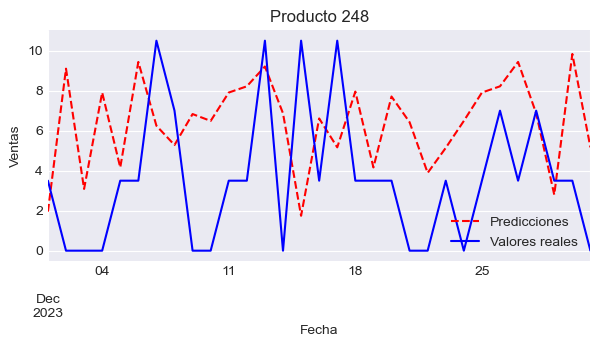

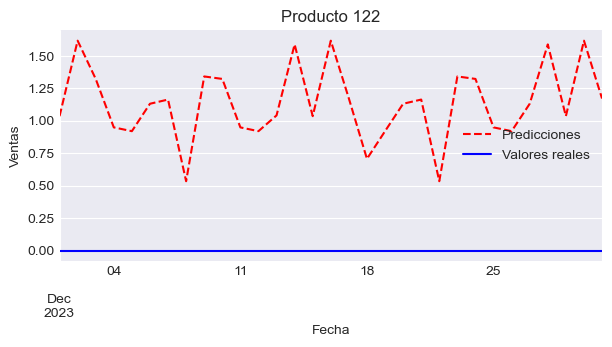

In [40]:
#Save figure#
for i in month_pred.columns:
    fig, ax=plt.subplots(figsize=(7, 3))
    month_pred[i].plot(ax=ax,color='red', linestyle='--', label='Predicciones')
    data.loc["2023-12-01":"2023-12-31",i].plot(ax=ax,color='blue', linestyle='-', label='Valores reales')
    ax.set_title(i)
    ax.legend()
    ax.set_ylabel('Ventas')
    ax.set_xlabel('Fecha')
    #plt.savefig(f"pred_mensual_{i}.png")
    

## Agregar modelo del otro producto y comparar

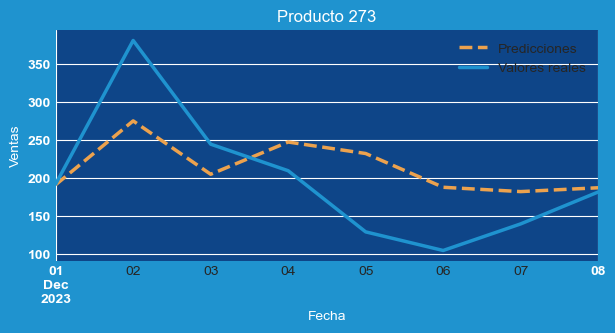

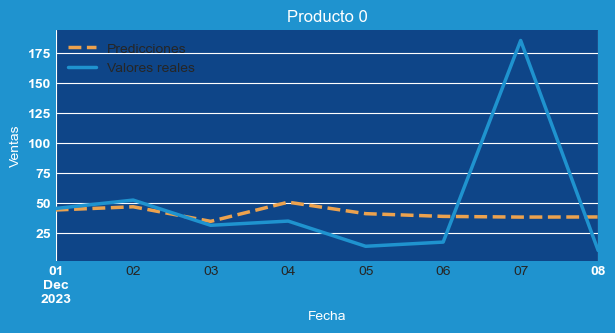

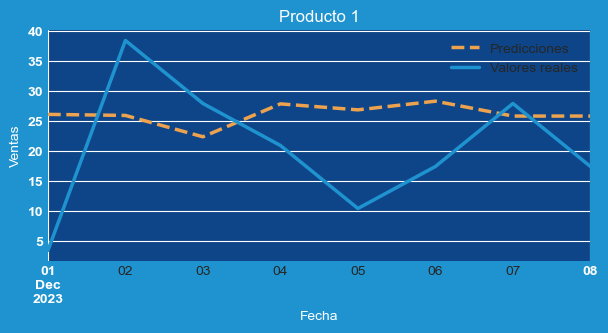

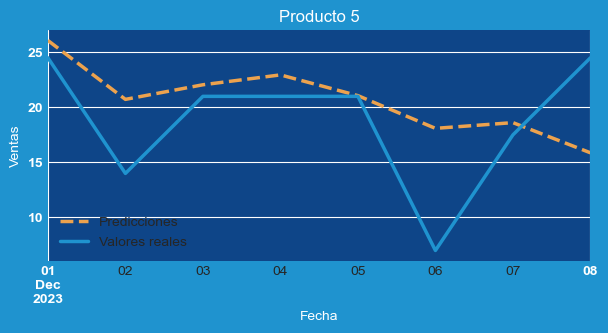

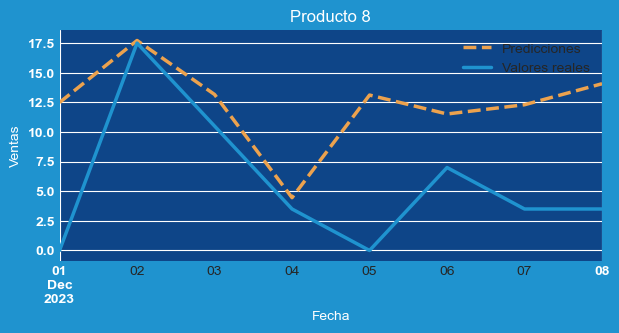

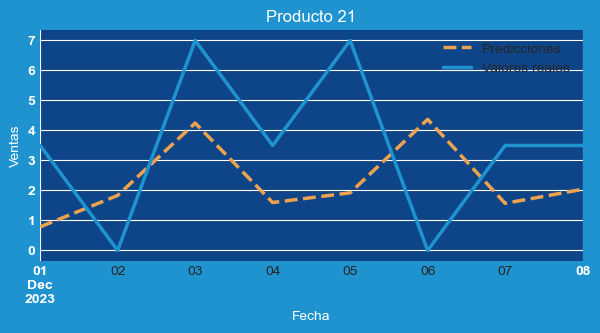

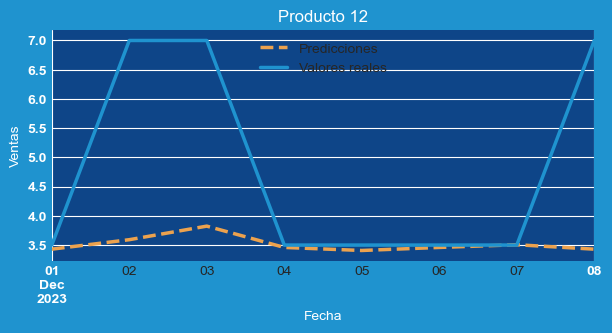

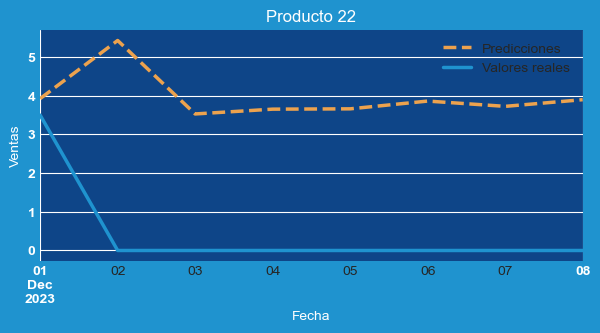

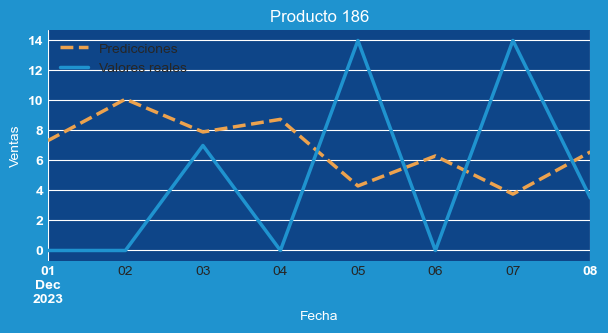

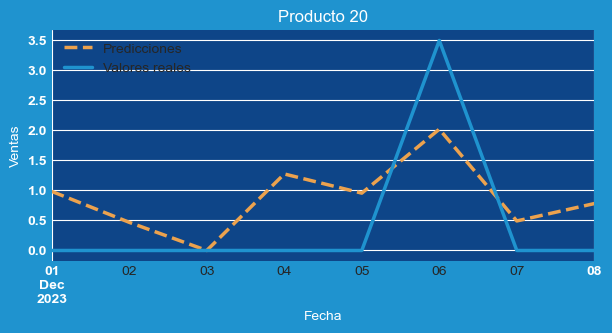

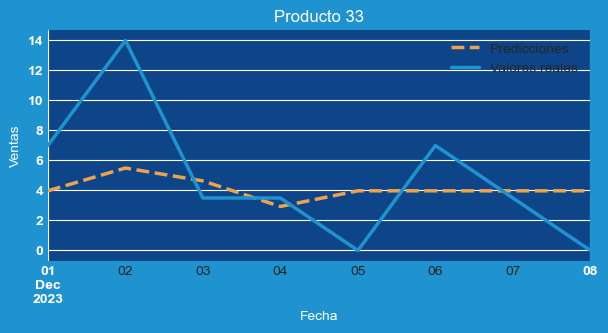

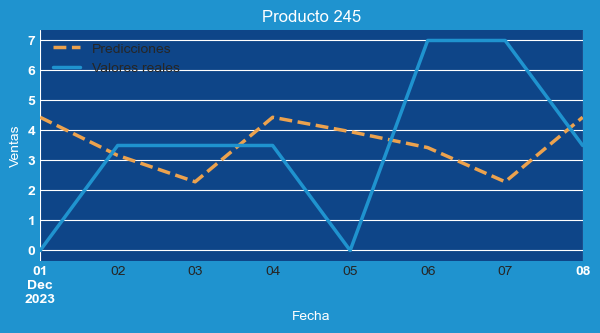

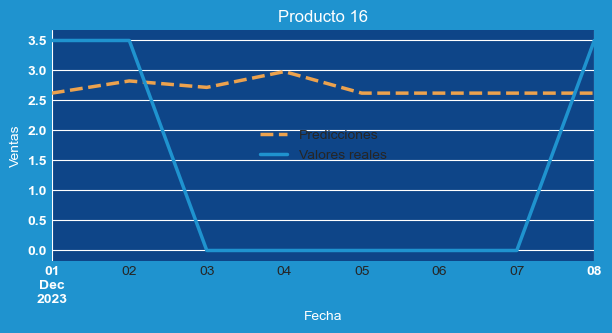

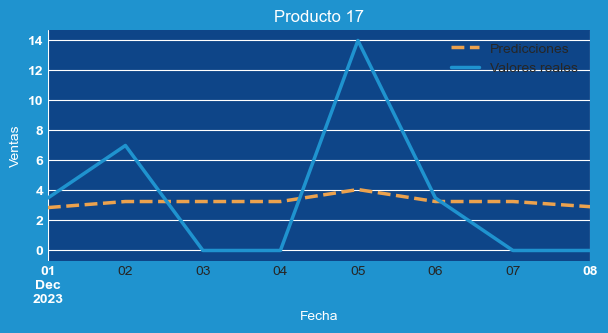

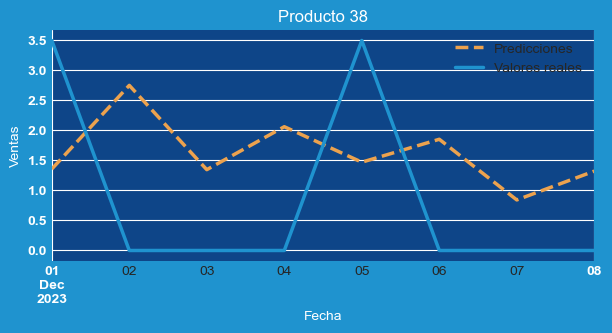

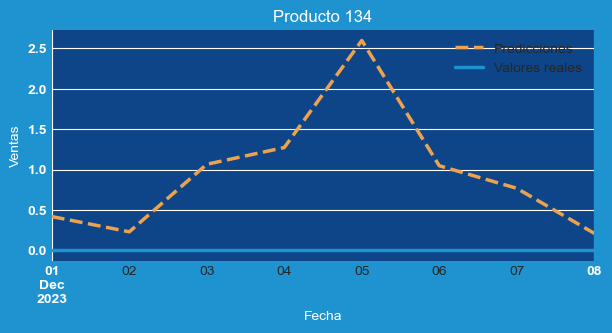

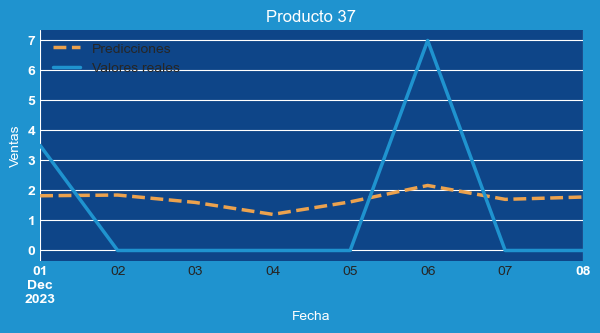

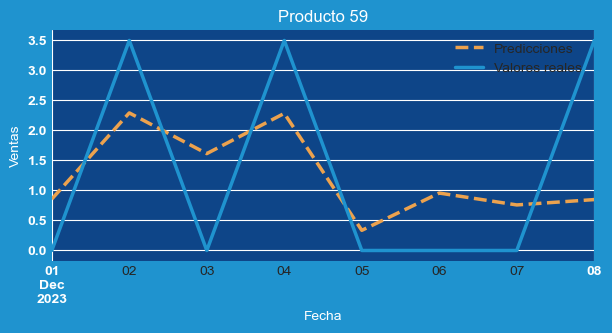

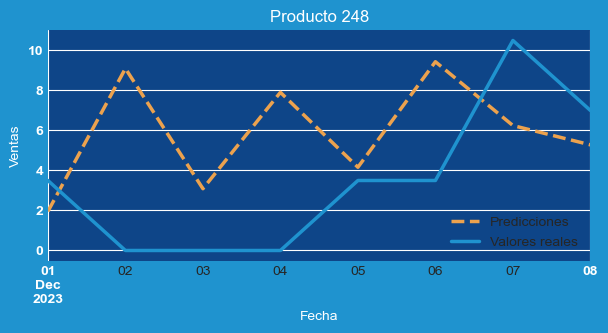

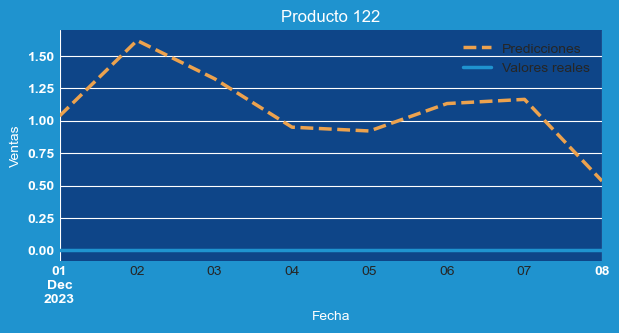

In [90]:
for i in week_pred.columns:
    fig, ax=plt.subplots(figsize=(7, 3))
    week_pred[i].plot(ax=ax,color='#ECA24E', linestyle='--', label='Predicciones', linewidth=2.5)
    data.loc["2023-12-01":"2023-12-08",i].plot(ax=ax,color='#1f93cf', linestyle='-', label='Valores reales', linewidth=2.5)
    ax.set_title(i, color = 'white')
    ax.set_facecolor('#0e4588')
    ax.grid(color='white')
    #ax.tick_params(axis='x', colors='white')
    #ax.spines['bottom'].set_color('white')
    #ax.spines['top'].set_color('white')
    #ax.xaxis.label.set_color('white')
    #ax.tick_params(axis='x', colors='white', labelsize = 10, which = 'major')
    fig.set_facecolor('#1f93cf')
    ax.set_ylabel('Ventas',color='white') 
    ax.set_xlabel('Fecha',color='white')
    plt.xticks(color='white', weight='bold')
    plt.yticks(color='white', weight='bold')
    #plt.legend(color='white')
    ax.legend()

In [ ]:
resid = data["Producto 0"].loc["2023-10-21":"2023-10-28"] - predicts

In [ ]:
week_pred.to_csv("predicciones_semanales_HGB.csv")
month_pred.to_csv("predicciones_mensuales_HGB.csv")
data.to_csv("datatop20.csv")

,Producto 273,Producto 0,Producto 1,Producto 5,Producto 8,Producto 21,Producto 12,Producto 22,Producto 186,Producto 20,Producto 33,Producto 245,Producto 16,Producto 17,Producto 38,Producto 134,Producto 37,Producto 59,Producto 248,Producto 122
2023-12-01,191.568635,44.241920,26.184245,26.074028,12.488096,0.787651,3.429695,3.927858,7.324022,0.984379,3.978594,4.440104,2.622576,2.860921,1.357833,0.419574,1.824171,0.856879,1.954742,1.035936
2023-12-02,275.633156,46.925787,26.008929,20.725320,17.719338,1.835158,3.591847,5.430823,10.089389,0.469039,5.498016,3.170399,2.825751,3.263814,2.751930,0.230753,1.847885,2.293071,9.100468,1.617229
2023-12-03,205.372151,34.773765,22.449637,22.052071,13.164492,4.247331,3.823965,3.530881,7.900793,0.000000,4.637185,2.289104,2.718295,3.263814,1.346992,1.065830,1.602324,1.614743,3.088791,1.322783
2023-12-04,247.810189,50.755710,27.934841,22.948310,4.455952,1.598692,3.459292,3.654907,8.743454,1.275361,2.932914,4.440104,2.981883,3.263814,2.062868,1.272860,1.203935,2.285042,7.906694,0.949515
2023-12-05,232.683095,41.185338,26.939218,21.064282,13.115563,1.922587,3.407166,3.663162,4.303401,0.955947,3.978594,3.961679,2.622576,4.062701,1.471656,2.596176,1.620143,0.335706,4.162075,0.920300
2023-12-06,188.224421,38.913195,28.384194,18.091801,11.517635,4.370891,3.459292,3.864032,6.300994,2.021659,3.978594,3.429625,2.622576,3.263814,1.853515,1.047474,2.167168,0.956964,9.437604,1.131519
2023-12-07,182.533458,38.331289,25.903319,18.613266,12.298853,1.571765,3.505475,3.727272,3.758627,0.492125,3.978594,2.289104,2.622576,3.263814,0.842675,0.768602,1.704188,0.759117,6.247438,1.163769
2023-12-08,187.592701,38.440135,25.903319,15.872234,14.070452,2.038564,3.429695,3.899998,6.572098,0.781859,3.978594,4.440915,2.622576,2.918250,1.322817,0.211841,1.781791,0.848580,5.282371,0.534871
2023-12-09,234.984092,37.902690,26.774874,17.228063,15.596747,2.481960,3.601068,3.938911,9.211254,1.111823,4.647223,3.429625,3.442045,3.263814,2.757661,0.342657,1.581131,1.613565,6.831312,1.341793
2023-12-10,216.779599,32.201267,26.488295,19.437686,13.669274,3.239626,3.848183,2.836979,8.786546,2.881347,4.669825,4.274207,2.718295,3.263814,1.346992,1.065830,1.906910,2.500628,6.488423,1.322783
